**Методы детектирования объектов**


Задача детектирования объектов определяется как задача автоматической
локализации объектов определѐнных классов на изображении. Метод
детектирования получает на вход изображение, выполняет его анализ и
возвращает набор ограничивающих окон (детекций) и значений вероятности
принадлежности классам для всех локализованных объектов. Работа
метода детектирования на примере алгоритма CenterNet представлена на
рисунке.


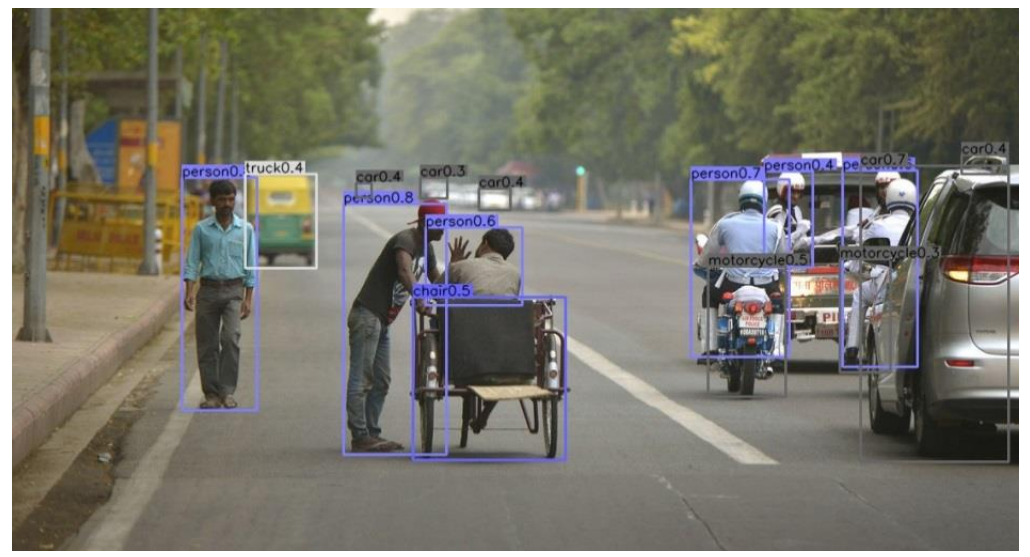

Современные решения задачи детектирования объектов, показывающие
удовлетворительные метрики качества, используют нейронные сети
Различают два вида методов детектирования: двухэтапные (two-stage) и
одноэтапные (one-stage). Двухэтапные методы разделяют процесс локализации
и классификации объектов и показывают наивысшие значения метрик качества
детектирования. Одноэтапные одновременно предсказывают ограничивающие
окна и значения степеней принадлежности классам для объектов, поэтому
работают с наибольшей скоростью. К методам детектирования, показывающим
наивысшие метрики качества, на данный момент можно отнести: Faster R-CNN
(двухэтапный), Mask R-CNN (двухэтапный), YOLOv3 (одноэтапный), YOLOv4
(одноэтапный), RefineDet (одноэтапный), NAS-FPN (одноэтапный), CenterNet
(одноэтапный) и другие.
В алгоритмах трекинга объектов часто используются такие одноэтапные
и двухэтапные нейросетевые методы детектирования как Faster R-CNN,
SSD, детекторы серии YOLO и другие.

CenterNet моделирует объект, как одну точку, которая находится в центре ограничительной рамки. Размер объекта, его ориентация, 3D-форма, направление, поза и т.д. извлекаются в последствии через характеристики изображения (image features) около полученной точки. Авторы подают входное изображение в полносвязную сверточную сеть, которая генерирует тепловую карту (heatmap). Пики на этой тепловой карте соответствуют центрам объектов. Характеристики изображения в каждом пике тепловой карты предсказывают размеры ограничительной рамки вокруг объекта. С помощью CenterNet авторы статьи экспериментируют с определением 3D размеров объектов и оценкой позы человека по двумерному изображению.

В другой статье исследователи используют 3 точки: левый верхний угол, правый нижний угол и центр объекта для более точного определения положения объекта.

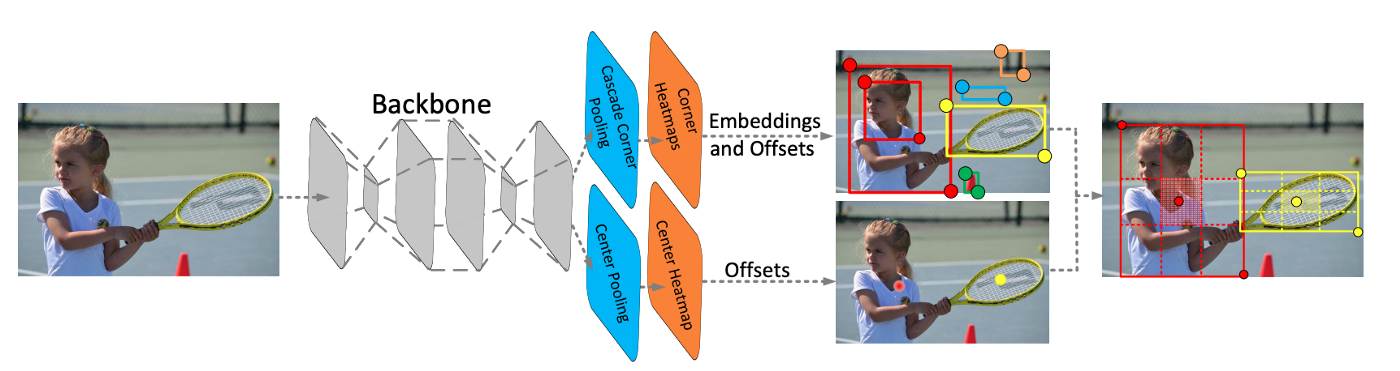

**Как работает CenterNet**


Поговорим о работе CenterNet: как мы преобразуем наши таргеты и что хотим получить. В нашем случае это heatmap – gray scale изображение, от нуля до единицы, где число каналов – по сути число классов. Помимо самой heatmap, у нас будут другие объекты, но сначала нужно разобраться, как получить heatmap. Мы прогоняем изначальную картинку через BackBone и таким образом мы можем уменьшить размерность изначальной картинки. В оригинальной статье получается heatmap в четыре раза меньше, чем наша изначальная картинка. Сначала прогоняем часть через Downsample, потом есть некоторый upcycling. В зависимости от архитектуры это либо просто deconvolution, либо вот как Hourglass – encoder decoder архитектура. На выходе есть какая-то heatmap и мы можем опционально немного ее улучшить с помощью преобразования через Гауссовский Kernel (gaussian kernel), который нам позволит размазать наши точки более, сделать их менее плотными, размазать их немного по нашей heatmap. Это делается с помощью такого преобразования.

Внизу есть стандартное отклонение, оно учитывает радиус нашего объекта. Преобразование нашей точки будет больше, если наш объект изначально был больше и будет меньше, если объект маленький. Для самой сети у нас есть три функции loss – мы решаем три задачи одновременно. Первая – это задача классификации по heatmap. В оригинальной статье используется Focal Loss, то есть некоторое улучшение cross entropy (перекрестной энтропии), которое позволяет меньше штрафовать те точки, которые и так хорошо угадываются, и больше штрафовать точки, которые угадываются хуже. Также есть loss на размер объекта – на самом деле мы по сути предсказываем две координаты, это широта-высота. У нас по сути три отдельных «головы» помимо нашего основного BackBone – сверху у нас три небольших сверточных нейронки, буквально несколько слоев. Помимо размера, мы хотим немножко скорректировать наши предсказания, так как мы делаем downsampling в heatmap, мы хотим небольшую погрешность тоже учитывать. С помощью функции L1 loss мы предсказываем Offset. Все три loss вместе взвешиваются. Наибольший вклад вносит первый loss, который мы предсказываем для heatmap.

**Декодируем**

После получения такой heatmap, мы хотим из нее получить bounding boxes. Как это можно сделать: мы используем pulling, например, max pulling 3х3, чтобы выделить top k peaks на heatmap. В оригинальной статье k = 100, но на самом деле это гиперпараметр, его можно менять. Необходимо выделить основные пики и каждый пик – это наш confidence объекта. Мы его сможем транжировать и преобразовать в привычное представление, bounding box confidence для каждого объекта. Bounding box высчитывается также благодаря тому, что мы посчитали размер объекта и его отступ. Эта дельта – наш отступ. Как вы видите, на моменте декодинга мы не используем какие-то сторонние алгоритмы вроде NMS (Non-maximum Suppression), как принято делать в классических детекторах. Используем только max pulling, что довольно упрощает наши вычисления на момент inference, потому что нам не нужно дополнительно использовать сложные надстройки. В этом большой плюс CenterNet. Также ненужно заранее отсчитывать и задавать anchor boxes – стадия постпроцессинга довольно простая.

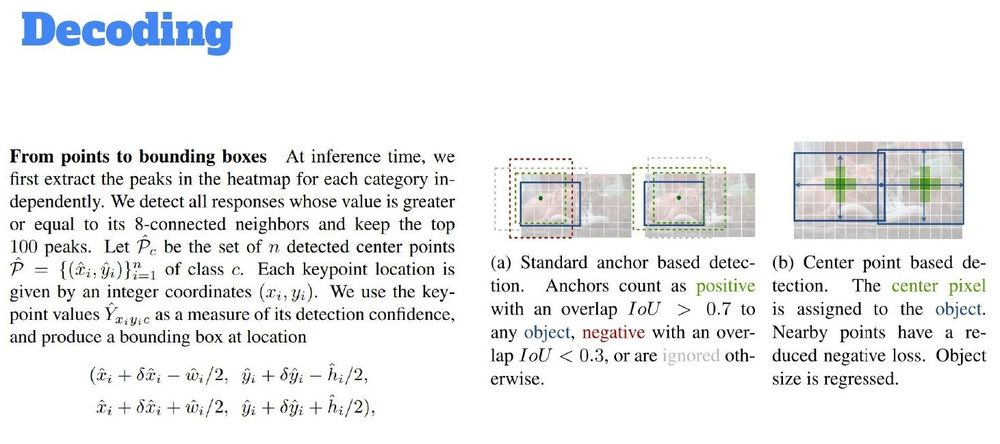

**Сравнение результатов**


Давайте посмотрим на сравнение BackBones, которые они использовали –  их было четыре. Стоит упомянуть, что время inference кажется быстрым – 14 миллисекунд. На самом деле, это на каком-то из TITAN, кажется TITAN X. Это inference на GPU и скажем так, довольно странно мерить такое, если вы хотите делать real-time сетку только на GPU. DLA предлагает trade-off и по качеству, и по скорости, а Hourglass показывает наилучшее качество, но при этом работает очень медленно. Также они сравнивают результаты с другими архитектурами, как двухстадийными, так и one-stage детекторами типа YOLO. Если брать кейс real-time детектора, то первое, что пришло нам в голову –  попробовать другие BackBone, которые заточены именно под эту задачу.

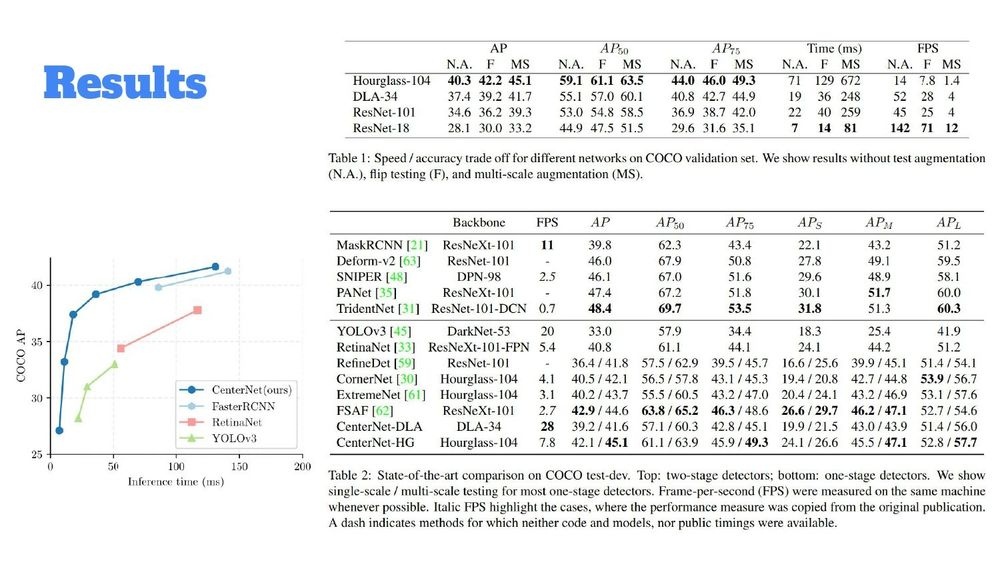

In [ ]:
Список используемой литературы
1) https://habr.com/ru/post/498168/
2) https://blog.xperience.ai/centernet-i-centertrack/
3) https://github.com/xingyizhou/CenterNet